In [4]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install scikit-image
!pip install sklearn
!pip install scipy
!pip install hdbscan
!pip install seaborn

You should consider upgrading via the '/Users/trevorchan/environments/machine-learning/bin/python3 -m pip install --upgrade pip' command.
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached scikit_learn-0.23.1-cp37-cp37m-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-0.15.1-py3-none-any.whl (298 kB)
    Running setup.py install for sklearn ... done
You should consider upgrading via the '/Users/trevorchan/environments/machine-learning/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/trevorchan/environments/machine-learning/bin/python3 -m pip install --upgrade pip' command.
Processing /Users/trevorchan/Library/Caches/pip/wheels/12/bb/54/7401fdc7883b5975dba5514a185d75d7a0986472df4957637b/hdbscan-0.8.26-cp37-cp37m-macosx_10_14_x86_64.whl
  Using cached Cython-0.29.20-cp37-cp37m-macosx_10_9_x86_64.whl (1.9 MB)
You should consider upgrading via the '/Users/trevorchan/envir

In [19]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from PIL import Image
import torch

from tqdm import tqdm

import seaborn as sns
import pickle

import cv2

#from skimage.draw import ellipse
#from skimage.measure import label, regionprops, find_contours, approximate_polygon
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

#from sklearn.cluster import DBSCAN
import hdbscan

In [206]:
#load model output into instances dict: 
instances = {}
with open('instances_small.data', 'rb') as filehandle:
#with open('instances.data', 'rb') as filehandle:
    instances = pickle.load(filehandle)
    
'''   "pred_boxes" "pred_masks" "scores" "classes"  "image_size" '''

'   "pred_boxes" "pred_masks" "scores" "classes"  "image_size" '

In [207]:
def make_adjacencies(instances, mindist = 15):
    #takes a list of n cell_poly objects
    #takes a minimum distance defined as adjacent
    #returns an adjacency list of length n

    centroid_list = []
    adjacency_list = []
    wide_list = []

    centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
    #print(len(centroid_list))
    centroid_list = np.array(centroid_list)

    polygon_list = [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]

    tree = []
    tree = KDTree(centroid_list, leaf_size=10)

    wide_list = tree.query_radius(centroid_list, mindist * 5)

    for i,small_list in tqdm(enumerate(wide_list)):
        adjacency_list.append (list())
        for index in small_list:
            # if we've already explored this pair then skip (as cdist _should_ be symmetrical)
            if index <= i:
                continue
            d = distance.cdist(polygon_list[i],polygon_list[index],'euclidean')
            if min(d.flatten()) < mindist:
                adjacency_list[i].append (index)
    
    return adjacency_list


In [208]:
mindist = 15

centroid_list = []
adjacency_list = []
wide_list = []

centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
#print(len(centroid_list))
centroid_list = np.array(centroid_list)

polygon_list = [ np.reshape(mask[0], (int(len(mask[0])/2) , 2)) for mask in instances["pred_masks"] ]

tree = []
tree = KDTree(centroid_list, leaf_size=10)

wide_list = tree.query_radius(centroid_list, mindist * 5)

for i,small_list in tqdm(enumerate(wide_list)):
    adjacency_list.append (list())
    for index in small_list:
        # if we've already explored this pair then skip (as cdist _should_ be symmetrical)
        if index <= i:
            continue
        d = distance.cdist(polygon_list[i],polygon_list[index],'euclidean')
        if min(d.flatten()) < mindist:
            adjacency_list[i].append (index)

446it [00:02, 168.82it/s]


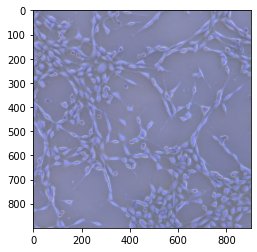

In [209]:
fig = plt.subplots()
plt.imshow(img)
#ax.add_line(lines.Line2D([centroid_list[0][0],centroid_list[1][0]], [centroid_list[0][1],centroid_list[1][1]]))
#plt.show()

In [210]:
import matplotlib.lines as lines



def plot_adjacencies(centroid_list, adjacency_list, img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    for a,i in enumerate(adjacency_list):
        for b in i:
            plt.plot([centroid_list[a][0],centroid_list[b][0]], [centroid_list[a][1],centroid_list[b][1]], color = 'r', linewidth = .2)
    
    plt.savefig('out.png', bbox_inches='tight', dpi = 300)
    plt.show()

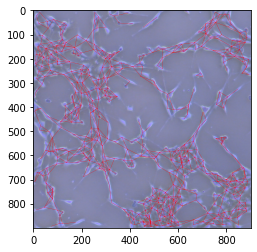

In [211]:
image_path = 'cl5-1111-small.JPG'
img = np.array(Image.open(image_path))

centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]
#print(len(centroid_list))
centroid_list = np.array(centroid_list)

plot_adjacencies(centroid_list, adjacency_list, img)
#plt.savefig('out.png', bbox_inches='tight')


In [214]:
import pickle

with open('adjacency_list.data', 'wb') as filehandle:
    pickle.dump(adjacency_list, filehandle)

#if haven't already, make centroid_list
#    centroid_list = [ (((box[0]+box[2])/2).item() , ((box[1]+box[3])/2).item()) for box in instances["pred_boxes"] ]

with open('centroid_list.data', 'wb') as filehandle:
    pickle.dump(centroid_list, filehandle)

In [181]:
for i,point in enumerate(centroid_list):
    print(i, point[0], point[1])

0 476.884033203125 457.0595703125
1 491.8338623046875 457.42022705078125
2 19.644001007080078 406.2657165527344
3 563.6055908203125 331.0072021484375
4 428.135009765625 171.2174835205078
5 656.0308837890625 790.6254272460938
6 490.7826843261719 774.0260009765625
7 282.96868896484375 377.12237548828125
8 677.48193359375 396.7582702636719
9 421.6074523925781 65.15113830566406
10 292.21307373046875 13.994543075561523
11 773.9390869140625 415.50860595703125
12 791.845947265625 8.171615600585938
13 340.3349609375 173.4959716796875
14 359.4888916015625 770.2811889648438
15 192.82476806640625 46.93571090698242
16 764.2801513671875 73.47118377685547
17 297.434326171875 435.28424072265625
18 599.4893798828125 36.86775207519531
19 790.80810546875 677.673828125
20 458.4374694824219 537.4403076171875
21 573.5388793945312 17.26740074157715
22 700.7052612304688 94.81356811523438
23 635.1397705078125 35.35523223876953
24 654.6878051757812 682.5479125976562
25 394.6084899902344 790.3252563476562
26 66

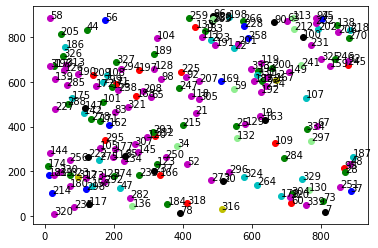

In [213]:

scatter_x = [[centroid_list[index][0] for index in shortlist] for shortlist in cluster_indices]
scatter_y = [[centroid_list[index][1] for index in shortlist] for shortlist in cluster_indices]
group = np.array([])
for i in range(len(cluster_indices)):
    a = np.full((len(cluster_indices[i])),i)
    group = np.append(group,a,0)
group = group.flatten()
group = group.astype(int)

cdict = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'lightgreen'}


fig, ax = plt.subplots()
for i in range(len(scatter_x)):
    #print((max(ix)-min(ix)))
    ax.scatter(scatter_x[i], scatter_y[i], c = cdict[i])
    for j, txt in enumerate(cluster_indices[i]):
        ax.annotate(txt, (scatter_x[i][j], scatter_y[i][j]))
plt.show()


In [161]:
scatter_x
a = [(x,y) for x,y in zip (scatter_x, scatter_y)]
b = [list(zip (x,y)) for x,y in a]
[ x.sort() for x in b ]
b

[[(75.17340087890625, 388.64727783203125),
  (152.82810974121094, 360.4461669921875),
  (175.8978271484375, 539.8082275390625),
  (197.96951293945312, 315.72161865234375),
  (209.54299926757812, 461.6206970214844),
  (303.4216613769531, 192.23822021484375),
  (402.2825927734375, 357.5570373535156),
  (408.6602783203125, 74.44830322265625),
  (489.8975524902344, 654.3485717773438),
  (570.619873046875, 542.6773681640625),
  (597.6619873046875, 503.3414611816406),
  (644.2529296875, 289.21331787109375),
  (775.022216796875, 340.26519775390625),
  (789.9842529296875, 732.5973510742188)],
 [(47.99872970581055, 653.1819458007812),
  (82.87734985351562, 646.8843994140625),
  (88.25438690185547, 252.73013305664062),
  (106.75269317626953, 312.9814453125),
  (114.30341339111328, 516.640625),
  (152.82337951660156, 57.45040512084961),
  (161.49588012695312, 401.720947265625),
  (169.34295654296875, 592.778076171875),
  (171.02444458007812, 484.0945129394531),
  (177.42401123046875, 138.71246337

In [205]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../.DS_Store
	modified:   Clustering.ipynb
	modified:   Density.ipynb
	modified:   morphological_analysis.ipynb
	modified:   updated_analysis.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../.gitignore
	../.ipynb_checkpoints/
	.DS_Store
	.ipynb_checkpoints/
	Untitled.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [204]:
!git add updated_analysis.ipynb

In [205]:
!git commit -m "more changes to updated_analysis"

[master 40d07e9] more changes to updated_analysis
 1 file changed, 434 insertions(+), 1150 deletions(-)
 rewrite morpho_scripts/updated_analysis.ipynb (60%)


In [206]:
!git push

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 4 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 203.78 KiB | 9.26 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/trevor-chan/research.git
   0f7fa68..40d07e9  master -> master
